In [2]:
!pip install unsloth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!export HF_TOKEN="your token"

In [ ]:
import os
from unsloth import FastVisionModel
import torch
from datasets import load_dataset
from transformers import TextStreamer
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

# Device setup (A100 uses CUDA)
device = torch.device("cuda")
print(f"Using device: {device}")

# 1. Load the model
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

# 2. Load the dataset
dataset = load_dataset("unsloth/Radiology_mini", split="train")
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        {"role": "user", "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]}
        ]},
        {"role": "assistant", "content": [
            {"type": "text", "text": sample["caption"]}
        ]},
    ]
    return {"messages": conversation}

converted_dataset = [convert_to_conversation(sample) for sample in dataset]

# 3. Before training
FastVisionModel.for_inference(model)
image = dataset[0]["image"]
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to(device)

print("\nBefore training:\n")
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                   use_cache=True, temperature=1.5, min_p=0.1)

# 4. Training
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=False,  # A100 supports bf16, so prefer it
        bf16=True,   # Optimize for A100
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

trainer_stats = trainer.train()

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

# 5. After training
print("\nAfter training:\n")
FastVisionModel.for_inference(model)
image = dataset[0]["image"]
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to(device)

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                   use_cache=True, temperature=1.5, min_p=0.1)

# 6. Save the model
# Save LoRA model
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

# Save merged model
output_dir = "Vashishta-S-2141/vlm"
model.save_pretrained_merged(output_dir, tokenizer, save_method="merged_16bit")

# Fix serialization issue by loading with weights_only=False
for file_name in os.listdir(output_dir):
    if file_name.endswith(".bin") or file_name.endswith(".safetensors"):
        file_path = os.path.join(output_dir, file_name)
        checkpoint = torch.load(file_path, map_location="cpu", weights_only=False)  # Key fix
        torch.save(checkpoint, file_path, _use_new_zipfile_serialization=True)

# Push to Hugging Face Hub
hf_token = os.environ.get("HF_TOKEN")
if hf_token:
    model.push_to_hub_merged(
        "Vashishta-S-2141/vlm",
        tokenizer,
        save_method="merged_16bit",
        token=hf_token
    )
else:
    print("HF_TOKEN not set; skipping push to hub.")

Using device: cuda
==((====))==  Unsloth 2025.3.17: Fast Mllama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients

Before training:

This radiograph appears to be a panoramic view of the upper jaw. The key features are:
Dense dark areas at the top of the image.
Dense black areas around the back teeth.
Dense dark area on the upper front teeth.
Inconspicuous shadow around the maxillary sinus.<|eot_id|>
GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
16.32 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,978 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)


Step,Training Loss
1,3.561400
2,3.631100
3,3.375800
4,3.188200
5,2.752900
6,2.534900
7,2.166400
8,1.984500
9,1.684700
10,1.326300


367.8824 seconds used for training.
6.13 minutes used for training.
Peak reserved memory = 16.32 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 41.257 %.
Peak reserved memory for training % of max memory = 0.0 %.

After training:

Panoramic radiography shows bilateral aneurysmal bone cysts (ABC) (arrowheads). Note that there is a round lucency in the mandibular right central incisor area (arrow).<|eot_id|>


Unsloth: Merging weights into 16bit:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  20%|██        | 1/5 [00:32<02:11, 32.93s/it]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  40%|████      | 2/5 [01:04<01:35, 31.87s/it]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  60%|██████    | 3/5 [07:30<06:27, 193.68s/it]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  80%|████████  | 4/5 [11:03<03:21, 201.37s/it]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [11:13<00:00, 134.76s/it]


UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [ ]:
# had to resume from here since model saving failed in the above cell


import os
import torch
from unsloth import FastVisionModel  # Only needed if reloading

# Assuming 'model' and 'tokenizer' are still in memory
# If not, reload them (uncomment if needed)
# model, tokenizer = FastVisionModel.from_pretrained("unsloth/Llama-3.2-11B-Vision-Instruct", load_in_4bit=True)
# model.load_pretrained("lora_model")  # Load LoRA weights if saved separately

# Directory where merged model was saved
output_dir = "Vashishta-S-2141/vlm"

# Skip manual re-saving and use the merged files as-is
print(f"Using existing merged files in {output_dir} without re-saving.")

# Push to Hugging Face Hub
hf_token = os.environ.get("HF_TOKEN")
if hf_token:
    model.push_to_hub_merged(
        "Vashishta-S-2141/vlm",
        tokenizer,
        save_method="merged_16bit",
        token=hf_token
    )
    print("Model pushed to Hugging Face Hub successfully!")
else:
    print("HF_TOKEN not set; skipping push to hub.")

# Optional: Verify the saved files
print("Listing files in output directory:")
for file_name in os.listdir(output_dir):
    print(f" - {file_name}")

Using existing merged files in Vashishta-S-2141/vlm without re-saving.


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  20%|██        | 1/5 [07:17<29:09, 437.30s/it]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  40%|████      | 2/5 [12:04<17:27, 349.02s/it]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  60%|██████    | 3/5 [13:35<07:42, 231.25s/it]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  80%|████████  | 4/5 [15:07<02:56, 176.32s/it]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [15:35<00:00, 187.11s/it]


Model pushed to Hugging Face Hub successfully!
Listing files in output directory:
 - config.json
 - special_tokens_map.json
 - tokenizer.json
 - model-00005-of-00005.safetensors
 - model-00004-of-00005.safetensors
 - model-00003-of-00005.safetensors
 - tokenizer_config.json
 - chat_template.json
 - model-00001-of-00005.safetensors
 - preprocessor_config.json
 - .cache
 - model.safetensors.index.json
 - generation_config.json
 - model-00002-of-00005.safetensors


#Testing

In [12]:
# !pip install git+https://github.com/unslothai/unsloth.git
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
# !pip install pillow transformers

In [6]:
# Install Unsloth from GitHub
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Install PyTorch with CUDA 12.1 (for Colab GPUs)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

# Install additional dependencies
!pip install pillow transformers

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-2j2d5_fx/unsloth_92e7fd688c38404e80cfb1b7f628c41f
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-2j2d5_fx/unsloth_92e7fd688c38404e80cfb1b7f628c41f
  Resolved https://github.com/unslothai/unsloth.git to commit e80d642bc777f7a219bdd34aea1a77751f066785
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached unsloth_zoo-2025.3.16-py3-none-any.whl.metadata (8.0 kB)
  Using cached tyro-0.9.17-py3-none-any.whl.metadata (9.5 kB)
  Using cached datasets-3.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached bitsandbytes-0.45.3-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached trl-0.15.2-py3-none-any.whl.metadata (11 kB)
  Using cached cut_cross_entropy-25.1.1-py3-none-any.whl.me

Using device: cuda
==((====))==  Unsloth 2025.3.18: Fast Mllama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Saving ROCOv2_2023_test_000868.jpg to ROCOv2_2023_test_000868 (2).jpg

Analyzing and displaying image...

Chest radiograph demonstrating a right-sided pneumatocele (arrow) as the primary finding in a patient with ARDS following intubation and mechanical ventilation (invasive ventilatory support).


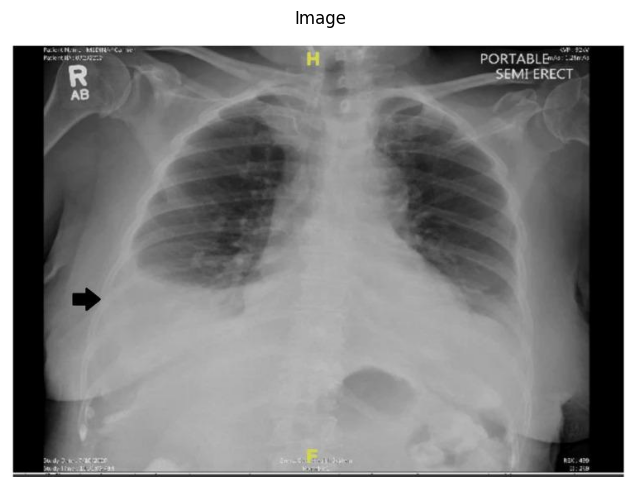


Caption: user

You are an expert radiographer. Describe accurately what you see in this image.assistant

Chest radiograph demonstrating a right-sided pneumatocele (arrow) as the primary finding in a patient with ARDS following intubation and mechanical ventilation (invasive ventilatory support).
GPU Memory Allocated: 13.51 GB
GPU Memory Reserved: 14.59 GB


In [8]:
import torch
from unsloth import FastVisionModel
from PIL import Image
from transformers import TextStreamer
import matplotlib.pyplot as plt
from google.colab import files

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and tokenizer from Hugging Face
model_name = "Vashishta-S-2141/vlm"
model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit=True  # Matches your training setup
)
model.eval()

# Instruction for radiology analysis
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

# Function to analyze and display image with caption below
def analyze_and_display_image(image_path):
    # Open and convert image
    image = Image.open(image_path).convert("RGB")

    # Prepare input for model
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to(device)

    # Generate caption, skipping prompt in streaming
    text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    with torch.no_grad():
        output_ids = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                                   use_cache=True, temperature=1.5, min_p=0.1)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    # Display image with "Image" title only
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title("Image", fontsize=12, pad=10)
    plt.show()

    return caption

# Upload a radiology image to Colab
uploaded = files.upload()  # Upload your radiology image (e.g., xray.jpg)

# Test the model and display result
image_path = list(uploaded.keys())[0]  # Get the uploaded file name
print("\nAnalyzing and displaying image...\n")
result = analyze_and_display_image(image_path)
print("\nCaption:", result)

# Check GPU memory (optional)
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Saving ROCOv2_2023_test_002037.jpg to ROCOv2_2023_test_002037 (1).jpg

Analyzing and displaying image...

The image is a computed tomographic (CT) scan of the abdomen showing a mass involving the subcutaneous and intra-abdominal fat, measuring 5 cm × 3 cm.


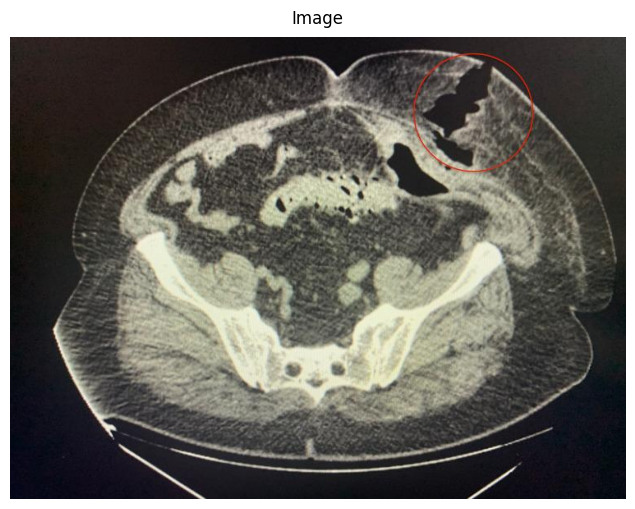


Caption: user

You are an expert radiographer. Describe accurately what you see in this image.assistant

The image is a computed tomographic (CT) scan of the abdomen showing a mass involving the subcutaneous and intra-abdominal fat, measuring 5 cm × 3 cm.
GPU Memory Allocated: 13.51 GB
GPU Memory Reserved: 14.59 GB


In [11]:
# Upload a radiology image to Colab
uploaded = files.upload()  # Upload your radiology image (e.g., xray.jpg)

# Test the model and display result
image_path = list(uploaded.keys())[0]  # Get the uploaded file name
print("\nAnalyzing and displaying image...\n")
result = analyze_and_display_image(image_path)
print("\nCaption:", result)

# Check GPU memory (optional)
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")